In [1]:
import os
import wave
import numpy as np


def load_wav_file(file_path):
    with wave.open(file_path, 'r') as wf:
        # Get audio parameters
        nchannels, sampwidth, framerate, nframes, comptype, compname = wf.getparams()

        # Read all frames as bytes
        frames = wf.readframes(nframes)

        # Convert bytes to a NumPy array of integers
        # 'int16' is common for 16-bit audio, adjust dtype based on sampwidth
        audio_data = np.frombuffer(frames, dtype=np.int16) 
        
        return audio_data, framerate, nchannels

file_name = "estocastico.wav"
base_path = os.getcwd()
audio_file = os.path.join( base_path, file_name)
audio_data, sr, channels = load_wav_file(audio_file)
print(f"Sample rate: {sr} Hz, Channels: {channels}")
print(f"Audio data shape: {audio_data.shape}")

Sample rate: 44100 Hz, Channels: 2
Audio data shape: (176400,)


### Ejercicio 1

Utilizando load (librosa), cargar el archivo de audio estocastico. wav
y escucharlo utilizando Audio (IPython.display)

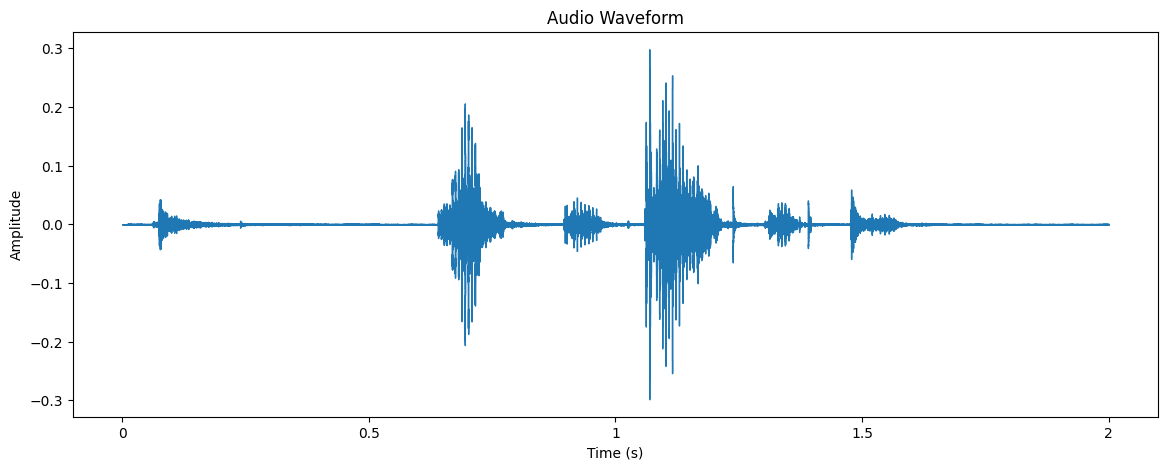

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt


y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [3]:
from IPython.display import Audio, display
display(Audio(audio_file))

### Ejercicio 2
Determinar aproximadamente los instantes de tiempo donde se pronuncian las vocales en el audio **estocastico.wav**. La función recortar de recorte.py puede ser útil

In [4]:
%load_ext autoreload
%autoreload 2
from recorte import recortar

In [5]:

from recorte import recortar
x,fs = librosa.load(audio_file)
print("Audio samples shape:", x.shape)
print("Sample rate:", fs)
markers = recortar(x,fs)

Audio samples shape: (44100,)
Sample rate: 22050


FloatSlider(value=5000.0, description='Inicio:', max=39100.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=39100.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

Los marcadores se encontraron en los siguientes intervalos de muestras:
<ol>
<li> 14100 - 15500 /e </li> 
<li> 14300 - 15600 </li>
<li> 17300 - 18500 /t </li>
<li> 20600 - 21200 /o </li>
<li> 22300 - 23600 /c </li>
<li> 23400 - 24400 /ca </li>
<li> 28500 - 29400 /t </li>
<li> 29300 - 30500 /i </li>
<li> 32300 - 33400 /c </li>
<li> 33800 - 35000 /o </li>
</ol>


### Ejercicio 3
Utilizando correlate(numpy) implementar una función que calcule los coefcientes LPC de una señal (representativa de un solo sonido) para N > M.

In [6]:
x_signal = x.copy()
print(x_signal[14100])
signal = x_signal[14100:15500]
print(signal)

-0.0008858831
[-0.00088588 -0.00099987 -0.00129919 ... -0.00519009  0.01441072
  0.02940374]


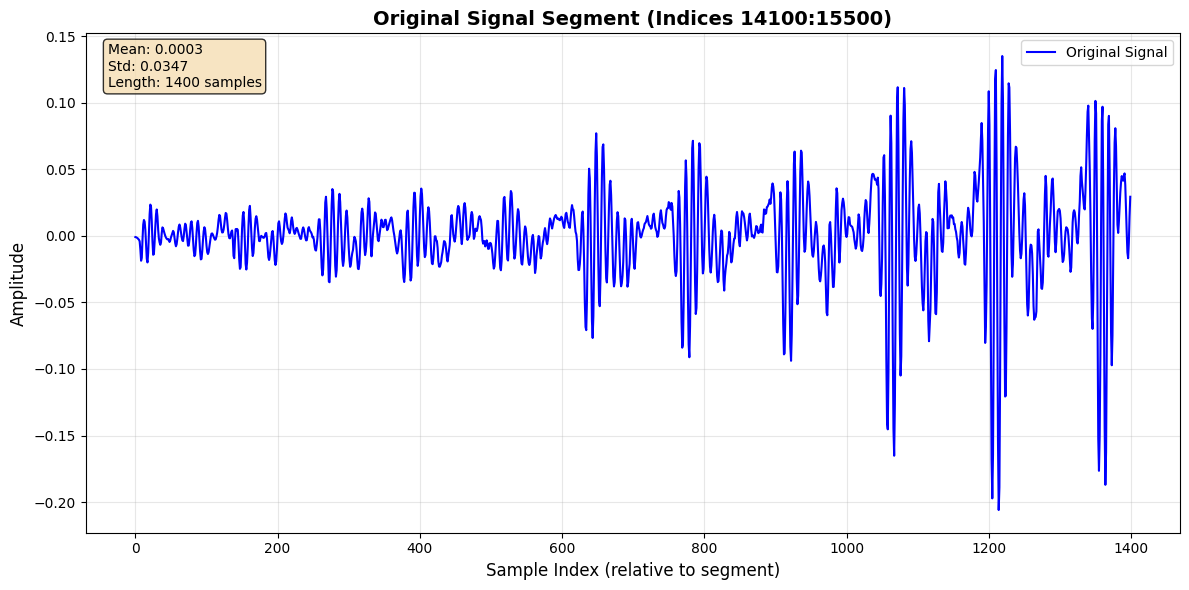

In [7]:

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.plot(signal, 'b-', linewidth=1.5, label='Original Signal')
plt.title('Original Signal Segment (Indices 14100:15500)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index (relative to segment)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Add some statistics as text
plt.text(0.02, 0.98, f'Mean: {np.mean(signal):.4f}\nStd: {np.std(signal):.4f}\nLength: {len(signal)} samples', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

signal_x = signal-np.mean(signal)

predict = np.zeros(len(signal_x)-1)
for order in range(1,len(signal_x)):
  autocorr = np.correlate(signal_x, signal_x, mode='full')
  autocorr = autocorr[len(signal_x)-1:]  # quedarse solo con los lags positivos
  R = np.array([[autocorr[abs(i - j)] for j in range(order)] for i in range(order)])  # matriz simétrica de autocorrelación
  r = autocorr[1:order+1]  # Autocorrelation vectors for lag-1
  h = np.linalg.inv(R)@r #Yule-Walker equations
  predict[order-1] = np.mean(signal)+np.dot(signal_x[-order:],h[::-1])

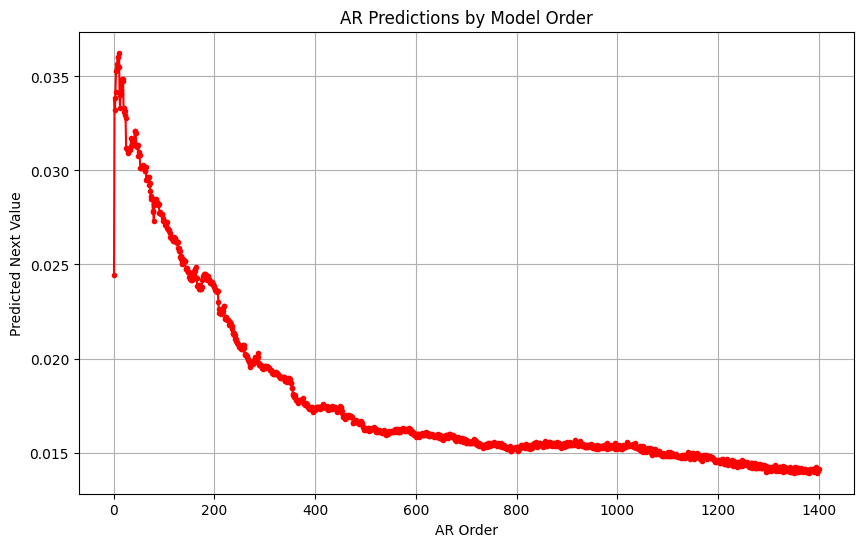

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predict)+1), predict, 'r.-')
plt.title('AR Predictions by Model Order')
plt.xlabel('AR Order')
plt.ylabel('Predicted Next Value')
plt.grid(True)
plt.show()

### Ejercicio 4
Asumiendo conocidos los coeficientes LPC, hallar analíticamente la respuesta impulsiva de un sistema LTI cuya entrada sea ${y[t]}$ y su salida $\hat{x}[t]$. Es decir,
hallar $h_{f}[t]\ \;|\; \hat{x}[t] = (y * h_{f})[t]$

Tenemos coeficientes conocidos $b_{0}, b_{1}....b_{M}$, por lo tanto se considerará la estimación de la salida como una combianción lineal de la señal de entrada $$\hat{x}[t] = y[t] - \sum_{k=0}^{M} h_{k}y[t-k]$$

Por otro lado, al aplicar la convolución tenemos que: $$(y*h_{f})[t] = \sum_{m=-\infty}^{\infty}y[m]h_{f}[t-m]$$

Al igual las dos expresiones (respecto a $\hat{x}[t]$), tenemos que:
$$\sum_{m=-\infty}^{\infty}y[m]h_{f}[t-m] = y[t] - \sum_{k=0}^{M} h_{k}y[t-k] $$

Al comparar los coeficientes desplazados del termino $y[t-m]$, tenemos que:
1. Para $\textit{m=0}$: el término $y_{t} = 1$ y $h_{f}[0]=1$
2. Para $\textit{m=k}$ con $\textit{k=1}$ hasta  $\textit{M}$, obtenemos que $h_{f}[k] = -h_{k}$ 
3. Para todos los otros $\textit{m} \neq \textit{k}$ , el coeficiente es ${0}, es decir $h_{f}[m] = 0$ para $m \notin \{0, 1, ...., \textit{M}\}$

En conclusión, el resultado se puede escribir como:

$$\boxed{h_{f} = \delta[t] - \sum_{k=1}^{M} h_{k}\delta[t-k]
}$$


### Ejercicio 5
Utilizando convolve (numpy) implementar una función que estime la
frecuencia de excitación a partir de la señal de un sonido y sus coeficientes LPC.

In [16]:
import numpy as np
import soundfile as sf

def lpc_coeffs(signal_frame, order):
    """
    Compute LPC coefficients for a frame using autocorrelation
    with numpy.convolve and Yule-Walker equations.
    """
    x = signal_frame - np.mean(signal_frame)  # zero mean

    # Autocorrelation
    autocorr = np.convolve(x, x[::-1], mode="full")
    autocorr = autocorr[len(x)-1:]

    # Autocorrelation matrix R and vector r
    R = np.array([[autocorr[abs(i - j)] for j in range(order)] for i in range(order)])
    r = autocorr[1:order+1]

    # AR coefficients (a_k)
    a = np.linalg.pinv(R) @ r
    return a


def lpc_residual(signal, fs, frame_ms=30, order=12):
    """
    Estimate excitation (residual) signal using LPC.
    """
    # Convert stereo -> mono if needed
    if signal.ndim > 1:
        signal = np.mean(signal, axis=1)

    frame_len = int(fs * frame_ms / 1000)
    hop_len = frame_len // 2

    residual = np.zeros(len(signal))
    prev_samples = np.zeros(order)

    for start in range(0, len(signal) - frame_len, hop_len):
        frame = signal[start:start+frame_len]

        a = lpc_coeffs(frame, order)

        # Concatenate previous memory with current frame
        extended = np.concatenate((prev_samples, frame))

        # Residual computation
        for n in range(order, len(extended)):
            past = extended[n-order:n][::-1]  # last 'order' samples
            residual[start + n - order] = extended[n] + np.dot(a, past)

       
        prev_samples = frame[-order:]

    return residual

### Ejercicio 6
Asumiendo conocidos los coeficientes LPC, hallar una solución analítica
para $H_{f} (e^{j\omega})$ (la respuesta en frecuencia del filtro del Ej. 4)

Tomando como punto de partida la ecuación del ejercio 4, tenemos que: 
$$h_{f} = \delta[t] - \sum_{k=1}^{M} h_{k}\delta[t-k]$$

con $n = 0, 1, 2...\textit{M}$

Tomando la **DTFT (Discrete-Time Fourier Transform)** para $h_{f}[n]$
$$H_{f}(e^{j\omega}) = \sum_{-\infty}^{\infty}h_{f}[n]e^{j\omega}$$

Posteriormente al sustituir los valores diferentes de cero en la ecuación anterior tenemos que:
$$\boxed{H_{f}(e^{j\omega})= 1 - \sum_{k=1}^{M}h_{k}e^{j\omega k}}$$

### Ejercicio 7
Asumiendo conocidos los coeficientes LPC, hallar una solución analítica
para $H_{i}(e^{j\omega})$ (la respuesta en frecuencia del filtro definido en (5), donde $\hat{x}[t]$ es la entrada y $\hat{y}[t]$ la salida)

La variable de entrada $\hat{y}[t]$ se puede escribir como:
$$\hat{y}[t] = a_{k}\sum_{k=0}^{P}\hat{x}[t-k]$$

De la definicion tenemos que:


$$\hat{X}(e^{j\omega}) = \hat{x}[t]\sum_{t=-\infty}^{\infty}(e^{-j\omega t}) \hspace{0.5cm}  e \hspace{0.5cm} \hat{Y}(e^{j\omega}) = \hat{y}[t] \sum_{t=-\infty}^{\infty}(e^{-j\omega t})$$

Aplicando a ambos lados, tenemos que: 

$$\hat{Y}(e^{j\omega}) = \sum_{t}\Big(a_{k}\sum_{k=0}^{P}\hat{x}[t-k]\Big)(e^{-j\omega t})$$
$$ \hspace{0.5cm}= \sum_{k=0}^{P}a_{k} \sum_{t}\hat{x}[t-k](e^{-j\omega t})$$

Haciendo cambio de variable $m=t-k$ tenemos que:
$$\sum_{t}\hat{x}[t-k](e^{-j\omega k}) = (e^{-j\omega k})\sum_{m}\hat{x}[m]  = (e^{-j\omega k})\hat{X}(e^{j\omega}) $$

Reemplazando el resultado obtenido en la ecuación original, tenemos que:
$$\hat{Y}(e^{j\omega}) = \hat{X}(e^{j\omega})\sum_{k=0}^{P}a_{k}(e^{-j\omega k})$$

Por tanto, la respuesta en frecuencia se puede escribir como: 
$$\boxed{\hat{H}(e^{j\omega}) = \sum_{k=0}^{P}a_{k} = a_{0} +  a_{1}(e^{-j\omega}) + a_{1}(e^{-2j\omega})....}$$






### Ejercicio 8

Implementar una función que represente el sistema descripto en (5) (entrada $\hat{x}[t]$ y salida $\hat{y}[t]$) a partir de su ecuacióon en diferencias. &#x1F480;  No trate encontrar la respuesta impulsiva $hi[t]$  definida en el Ej. 7 porque la misma posee duración infinita.

Del ejercicio (5) tenemos que: 
$$\hat{y}[t] = -\sum_{k=1}^{p}a_{k}\hat{y}[t-k] + \hat{x}[t]$$

Considerando hasta el termino $p=3$ la ecuacion anterior puede ser escrita como:
$$\hat{y}[t] = -a_{1}\hat{y}[t-1] -a_{2}\hat{y}[t-2] - a_{3}\hat{y}[t-3] + \hat{x}[t]$$

### Ejercicio 9

Utilizando la función desarrollada en el Ej. 3, calcular los coeficientes
LPC del audio estocástico.wav para cada ventana de tiempo de la señal. Utilizar
la ventana de hamming (numpy).

In [11]:
import numpy as np

def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def frame_signal(signal, frame_len, hop):
    # returns array of shape (num_frames, frame_len)
    num_frames = 1 + (len(signal) - frame_len) // hop
    frames = np.stack([signal[i*hop : i*hop + frame_len] for i in range(num_frames)])
    return frames

def autocorr(x, order):
    # biased autocorrelation (common for LPC). x is 1D array.
    N = len(x)
    r = np.zeros(order + 1)
    for k in range(order + 1):
        r[k] = np.dot(x[:N-k], x[k:N])
    return r

def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    a[0] = 1.0
    if r[0] == 0:
        return a, 0.0
    e = r[0]
    for i in range(1, order + 1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i - j]
        k = -acc / e
        # update coefficients
        a_prev = a.copy()
        a[1:i] = a_prev[1:i] + k * a_prev[i-1:0:-1]
        a[i] = k
        e *= (1 - k*k)
        if e <= 0:
            e = 1e-12
    return a, e

def lpc_from_frame(frame, order, pre_emph=0.0):
    if pre_emph:
        frame = pre_emphasis(frame, alpha=pre_emph)
    # Hamming window
    w = np.hamming(len(frame))
    xw = frame * w
    r = autocorr(xw, order)
    a, e = levinson_durbin(r, order)
    return a, e


if __name__ == "__main__":
    import scipy.io.wavfile as wav
    sr, sig = wav.read("estocastico.wav")
    if sig.ndim > 1:
        sig = sig.mean(axis=1)

    # normalize
    sig = sig.astype(float)
    sig -= np.mean(sig)
    sig /= max(1e-8, np.max(np.abs(sig)))

    frame_ms = 25
    frame_len = int(sr * frame_ms / 1000)
    hop = frame_len // 2   # 50% overlap
    order = 12
    pre = 0.97

    frames = frame_signal(sig, frame_len, hop)
    lpc_coeffs = []
    errors = []
    for f in frames:
        a, e = lpc_from_frame(f, order, pre_emph=pre)
        lpc_coeffs.append(a)
        errors.append(e)

    lpc_coeffs = np.array(lpc_coeffs)  # shape (num_frames, order+1)
    print("LPC shape:", lpc_coeffs.shape)


LPC shape: (159, 13)


### Ejercicio 10

Utilizando specgram (matplotlib) graficar un espectrograma del audio **estocastico.wav**, configurando sus paráametros según lo discutido previamente

LPC shape: (159, 13)


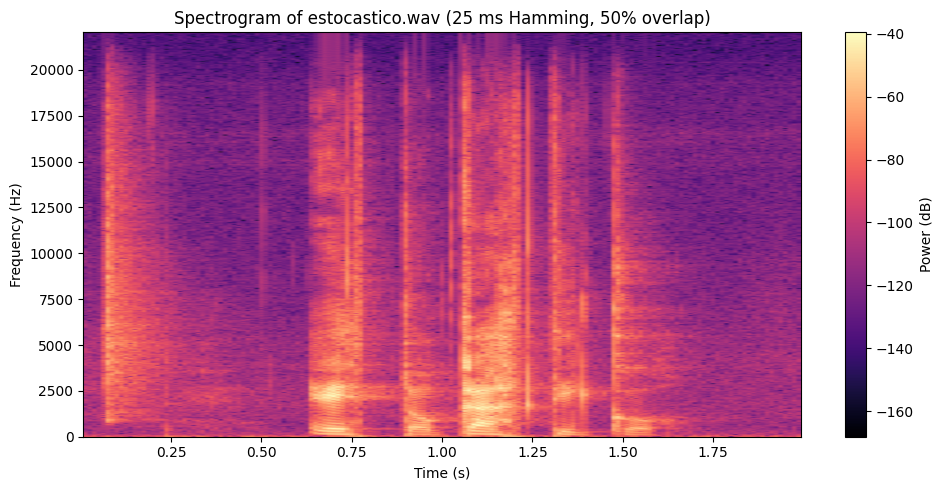

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def frame_signal(signal, frame_len, hop):
    num_frames = 1 + (len(signal) - frame_len) // hop
    frames = np.stack([signal[i*hop : i*hop + frame_len] for i in range(num_frames)])
    return frames

def autocorr(x, order):
    N = len(x)
    r = np.zeros(order + 1)
    for k in range(order + 1):
        r[k] = np.dot(x[:N-k], x[k:N])
    return r

def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    a[0] = 1.0
    if r[0] == 0:
        return a, 0.0
    e = r[0]
    for i in range(1, order + 1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i - j]
        k = -acc / e
        a_prev = a.copy()
        a[1:i] = a_prev[1:i] + k * a_prev[i-1:0:-1]
        a[i] = k
        e *= (1 - k*k)
        if e <= 0:
            e = 1e-12
    return a, e

def lpc_from_frame(frame, order, pre_emph=0.0):
    if pre_emph:
        frame = pre_emphasis(frame, alpha=pre_emph)
    w = np.hamming(len(frame))
    xw = frame * w
    r = autocorr(xw, order)
    a, e = levinson_durbin(r, order)
    return a, e

if __name__ == "__main__":
    # --- Load audio ---
    sr, sig = wav.read("estocastico.wav")
    if sig.ndim > 1:
        sig = sig.mean(axis=1)

    sig = sig.astype(float)
    sig -= np.mean(sig)
    sig /= max(1e-8, np.max(np.abs(sig)))

    # Params
    frame_ms = 25
    frame_len = int(sr * frame_ms / 1000)
    hop = frame_len // 2   # 50% overlap
    order = 12
    pre = 0.97

    # LPC per frame
    frames = frame_signal(sig, frame_len, hop)
    lpc_coeffs = []
    errors = []
    for f in frames:
        a, e = lpc_from_frame(f, order, pre_emph=pre)
        lpc_coeffs.append(a)
        errors.append(e)

    lpc_coeffs = np.array(lpc_coeffs)
    print("LPC shape:", lpc_coeffs.shape)

    # Plotting the spectogram
    NFFT = frame_len  # match LPC frame length
    plt.figure(figsize=(10, 5))
    Pxx, freqs, bins, im = plt.specgram(sig,
                                        NFFT=NFFT,
                                        Fs=sr,
                                        window=np.hamming(frame_len),  # matches LPC window
                                        noverlap=hop,
                                        mode='psd',
                                        cmap="magma")

    plt.title("Spectrogram of estocastico.wav (25 ms Hamming, 50% overlap)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, sr/2)
    plt.colorbar(im).set_label("Power (dB)")
    plt.tight_layout()
    plt.show()

### Ejercicio 11

Elegir los coeficientes LPC correspondientes a una ventana de tiempo
de la letra $/e/$. Graficar $|H_{f}(e^{jw})\vert$ y $\vert H_{i}(e^{jw})j\vert$

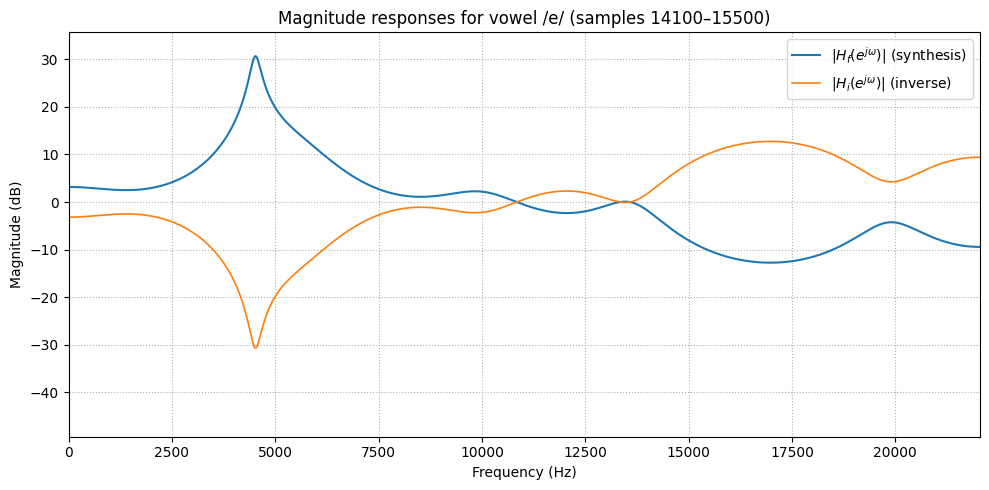

In [ ]:
signal_e = x_signal[14100:15500]
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Parameters
order = 12     
pre_emph = 0.97
eps = 1e-12

# Extract /e/ segment
signal_e = x_signal[14100:15500].astype(float)

signal_e = np.append(signal_e[0], signal_e[1:] - pre_emph * signal_e[:-1])
# Applying the Hamming window
signal_e = signal_e * np.hamming(len(signal_e))

# LPC coefficients for /e/ vocal 
def autocorr(x, order):
    N = len(x)
    r = np.zeros(order + 1)
    for k in range(order + 1):
        r[k] = np.dot(x[:N-k], x[k:N])
    return r

def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    a[0] = 1.0
    e = r[0]
    for i in range(1, order + 1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k = -acc / e
        a_prev = a.copy()
        a[1:i] = a_prev[1:i] + k * a_prev[i-1:0:-1]
        a[i] = k
        e *= (1 - k*k)
        if e <= 0:
            e = eps
    return a, e

r = autocorr(signal_e, order)
A, err = levinson_durbin(r, order)

# Frequency responses
n_freqs = 4096
w, H_A = freqz(A, worN=n_freqs, fs=fs)    # A(e^{jω})
H_synth = 1.0 / (H_A + eps)                # H_f(e^{jω})

# Magnitude in dB
mag_inv_db   = 20 * np.log10(np.abs(H_A) + eps)      # |H_i|
mag_synth_db = 20 * np.log10(np.abs(H_synth) + eps)  # |H_f|


# Plot the result
plt.figure(figsize=(10,5))
plt.plot(w, mag_synth_db, label=r'$|H_f(e^{j\omega})|$ (synthesis)', linewidth=1.5)
plt.plot(w, mag_inv_db, label=r'$|H_i(e^{j\omega})|$ (inverse)', linewidth=1.2)
plt.title("Magnitude responses for vowel /e/ (samples 14100–15500)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, fs/2)
plt.ylim(max(mag_synth_db)-80, max(mag_synth_db)+5)
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


### Ejercicio 12

Utilizando la función desarrollada en el Ej. 5, estimar la función de excitacin $\hat{x}[t]$ del audio **estocastico.wav** cuidando de evitar los transitorios del filtro.
Esto puede hacerse conservando los transitorios finales de cada sección, y sumándolos al siguiente segmento.

In [17]:
signal, fs = sf.read("estocastico.wav")
residual = lpc_residual(signal, fs, frame_ms=30, order=12)
sf.write("excitation.wav", residual, fs)